# Using Firefly to Explore OpenUniverse2024 Data Preview Simulated Roman and Rubin Images

- creation date : 2025-03-14
- Last update : 2025-04-24 
- on my laptop kernel `romanlsst_py311`. --> conda_py311 (april 2025)

https://caltech-ipac.github.io/irsa-tutorials/tutorials/firefly/OpenUniverse2024Preview_Firefly.html

Introduction

The purpose of this tutorial is to become familiar with simulated Roman and Rubin simulated data published through the OpenUniverse 2024 data preview, and to become familiar with the Firefly JupyterLab Extension for visualizing astronomical data products.

OpenUniverse2024 is a project to simulate spatially overlapping imaging surveys to be carried out by the Nancy Grace Roman Telescope and the Vera C. Rubin Observatory. The simulations were carried out on Argonne’s Theta cluster and consist of:

    The LSST ELAIS-S1 Deep Drilling Field (DDF)

    The Roman Time-Domain Survey (TDS) shifted to overlap the ELAIS region and LSST DDF

    Overlapping LSST Wide-Fast-Deep (WFD) survey (with rolling cadence)

    Overlapping Roman Wide-Area Survey (WAS) in the same region

    A deep-field calibration region of the Roman WAS in the same region

This data preview release consists of a subset of data from each of the five categories above. More information about data preview can be found at IRSA holding of this dataset.

Firefly is an open-source web-based UI library for astronomical data archive access and visualization developed at Caltech and used by multiple space- and ground-based astrophysics archives. More information on Firefly can be found here.

In addition to being used to make web applications, Firefly can be used from Python. More information on Firefly Python client can be found here.

The Firefly JupyterLab Extension makes it particularly easy to use Firefly to efficiently visualize cloud-hosted astronomical data using JupyterLab instances running locally or on cloud. More information on Firefly JupyterLab Extension can be found here.

## Imports

    astropy.io.fits for accessing FITS files
    numpy for numerical computing
    s3fs for browsing cloud buckets
    matplotlib.pyplot for creating static visualizations of FITS images
    matplotlib.patches for annotating visualizations of FITS images
    astropy.wcs for dealing with astronomical world coordinate systems
    astropy.units for dealing with astronomical units
    astropy.coordinates.SkyCoord for dealing with astronomical coordinates
    firefly_client.FireflyClient for using the Firefly python client
    astropy.nddata.Cutout2D for making image cutouts
    itertools.product to support looping over Roman blocks
    reproject.reproject_interp to convert Roman coadds from STG to TAN projection
    io.BytesIO for writing a fits file to an in-memory stream

In [1]:
#Uncomment the next line to install dependencies if needed.
# !pip install numpy astropy s3fs matplotlib firefly_client reproject

In [2]:
from astropy.io import fits
import numpy as np
import s3fs
from matplotlib import pyplot as plt
from matplotlib import patches
from astropy import wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from firefly_client import FireflyClient
from astropy.nddata import Cutout2D
from itertools import product
from reproject import reproject_interp
from io import BytesIO

## Learn where the OpenUniverse2024 data are hosted in the cloud.

The OpenUniverse2024 data preview is hosted in the cloud via Amazon Web Services (AWS). To access these data, you need to create a client to read data from Amazon’s Simple Storage Service (s3) buckets, and you need to know some information about those buckets. The OpenUniverse2024 data preview contains simulations of the Roman Wide-Area Survey (WAS) and the Roman Time Domain Survey (TDS). In this tutorial, we will focus on the WAS.

In [3]:
BUCKET_NAME = "nasa-irsa-simulations"
ROMAN_PREFIX = "openuniverse2024/roman/preview"
ROMAN_COADD_PATH = f"{ROMAN_PREFIX}/RomanWAS/images/coadds"
TRUTH_FILES_PATH = f"{ROMAN_PREFIX}/roman_rubin_cats_v1.1.2_faint"

RUBIN_PREFIX = "openuniverse2024/rubin/preview"
RUBIN_COADD_PATH = f"{RUBIN_PREFIX}/u/descdm/preview_data_step3_2877_19_w_2024_12/20240403T150003Z/deepCoadd_calexp/2877/19"

### Roman Coadds
The Nancy Grace Roman Space Telescope will carry out a wide-area survey (WAS) in the near infrared. The OpenUniverse2024 data preview includes coadded mosaics of simulated WAS data, created with the IMCOM algorithm (Rowe et al. 2011). Bands include F184, H158, J129, K213, Y106. In this section, we define some functions that make it convenient to retrieve a given cloud-hosted simulated Roman coadd based on position and filter.

#### Define Roman Simulated “Blocks”
The simulated Roman coadds are arranged in 100 arcsecond blocks, as described in Hirata et al. 2024. Below we define the RA and Dec of the block centers. This cell should not be altered.

In [4]:
#Centers of roman data preview blocks. Do not alter.
ra_block_centers = np.array([9.76330352298415, 9.724522605135252, 9.68574158906671,
                        9.646960496603766, 9.608179349571955, 9.56939816979703,
                        9.530616979104877, 9.491835799321422, 9.453054652272561,
                        9.414273559784032, 9.375492543681393, 9.336711625789874]) * u.deg
dec_block_centers = np.array([-44.252584927082495, -44.22480733304182, -44.197029724175756,
                            -44.16925210374898, -44.14147447502621, -44.11369684127218,
                            -44.08591920575162, -44.05814157172923, -44.03036394246976,
                            -44.0025863212379, -43.974808711298394, -43.94703111591591]) * u.deg
block_size = 100 * u.arcsec # each block is 100 arcsec across

#### Define a function that returns the simulated Roman block column/row for a given RA/Dec.

Blocks are arranged in a grid with axes parallel to RA and Dec. A given RA represents a column of blocks and a given Dec represents a row of blocks. This function returns the block column or row given the block centers from the cell above and a given RA or Dec, respectively.

In [5]:
def get_block_axis(block_centers, coord, ra_or_dec):
    ra_or_dec_coord = getattr(coord, ra_or_dec)
    block_dist_array = np.absolute(block_centers - ra_or_dec_coord)
    closest_block_idx = block_dist_array.argmin()
    if (ra_or_dec_coord < block_centers.min()-block_size/2 
        or ra_or_dec_coord > block_centers.max()+block_size/2):
        raise ValueError(f"Chosen {ra_or_dec}: {ra_or_dec_coord} not covered by OpenUniverse 2024 data preview simulated Roman coadds")
    else:
        return closest_block_idx + 12 # preview covers central 12 rows 12 columns, in a grid of 36x36 blocks

#### Define a function that retrieves a Roman simulated coadd given a sky position and filter
Each of the cloud-hosted simulated Roman coadds can be accessed via a S3 filepath. This function returns the access path for the simulated Roman coadd that includes a specified position on the sky and desired filter.

In [6]:
def get_roman_coadd_fpath(coord, filter):
    col = get_block_axis(ra_block_centers, coord, 'ra')
    row = get_block_axis(dec_block_centers, coord, 'dec')
    
    # Construct the coadd filename from the chosen filter, row, and column.
    coadd_fname_root = f"prod_{filter[0]}_{col}_{row}_map.fits"
    coadd_fpath = f"{BUCKET_NAME}/{ROMAN_COADD_PATH}/{filter}/Row{row}/{coadd_fname_root}"
    return coadd_fpath

Now we use this access path and prefix it with s3:// and use astropy.fits to extract a subset of it (for more info see this section of astropy docs).

We use .section to retrieve just the science image data from fits HDU as a 2D numpy.array, and extract WCS information from fits header as astropy.wcs.WCS object. The following function returns a dictionary of both.

In [7]:
def get_roman_coadd(coord, filter):
    # retrive fits file of block/tile from the coadd mosiac
    coadd_s3_fpath = get_roman_coadd_fpath(coord, filter)
    coadd_s3_uri = f"s3://{coadd_s3_fpath}"

    with fits.open(coadd_s3_uri, fsspec_kwargs={"anon": True}) as hdul:
        # retrieve science data from coadd fits
        coadd_data = hdul[0].section[0,0, :, :]  # has (2688, 2688, 15, 1) shape, with 0th layer in the cube as science image

        # make wcs using header
        coadd_wcs = wcs.WCS(hdul[0].header, naxis=2)

        return {'data': coadd_data, 'wcs': coadd_wcs}

#### Inspect a simulated Roman Coadd
Choose a filter and position that lies within the data preview region

In [8]:
coord = SkyCoord(ra=9.6055383, dec=-44.1895542, unit="deg")
filter_roman = 'H158' #F184, H158, J129, K213, and Y106 are available in the data preview

Retrieve the data and header information from the simulated Roman coadd corresponding to the chosen position and filter.

In [9]:
coadd_roman = get_roman_coadd(coord, filter_roman)

#### Understand the size of a simulated Roman coad

In [10]:
# Number of pixels (Y, X)
coadd_roman['data'].shape

(2688, 2688)

In [11]:
# Pixel size (scale Y, scale X) [degrees/pixel]
coadd_roman['wcs'].proj_plane_pixel_scales()

[<Quantity 1.08506944e-05 deg>, <Quantity 1.08506944e-05 deg>]

In [12]:
# Coadd size (FOV Y, FOV X)
[(num * size).to('arcsec') for num, size in zip(
    coadd_roman['data'].shape, coadd_roman['wcs'].proj_plane_pixel_scales())]

[<Quantity 105. arcsec>, <Quantity 105. arcsec>]

The field of view of Roman coadd is ~100 arcsec.

#### Use the WCS from the Roman simulated header to convert the specified coordinate into a pixel position.

In [13]:
def coord_to_xy(w, coord):
    return w.world_to_array_index(coord)[::-1] #reverse since 0th axis is y, 1st axis is x

coord_arr_idx = coord_to_xy(coadd_roman['wcs'], coord)
coord_arr_idx

(1513, 2049)

#### Use matplotlib imshow to create a static visualization of the Roman simulated coadd and overplot the selected position.

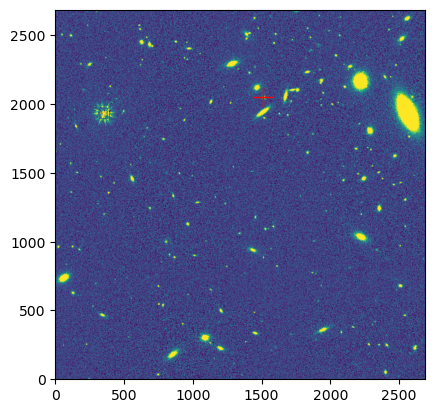

In [14]:
def stretch_color(data, clipPercent):
    return np.percentile(data, (0 + clipPercent, 100 - clipPercent))

plt.imshow(coadd_roman['data'], origin='lower', 
           clim=stretch_color(coadd_roman['data'], 1)
           )

plt.plot(*coord_arr_idx, 'r+', markersize=15)

### Rubin Coadds
The OpenUniverse2024 data preview includes coadded mosaics in the following filters: u, g, r, i, z, y. In this section, we define some functions that make it convenient to retrieve a given cloud-hosted simulated Roman coadd based on position and filter.

#### Retrieve Rubin Coadds
The OpenUniverse2024 data preview includes only one simulated Rubin coadd per filter. Below we define functions that make it convenient to retrieve the simulated Rubin coadd corresponding to the desired filter. We return data in same structure as the functions we defined above for Roman.

In [15]:
def get_rubin_coadd_fpath(filter): 
    coadd_fname_root = f"deepCoadd_calexp_2877_19_{filter}_DC2_u_descdm_preview_data_step3_2877_19_w_2024_12_20240403T150003Z.fits"
    coadd_fpath = f"{BUCKET_NAME}/{RUBIN_COADD_PATH}/{filter}/{coadd_fname_root}"
    return coadd_fpath

In [16]:
def get_rubin_coadd(filter):
    coadd_s3_fpath = get_rubin_coadd_fpath(filter)

    with fits.open(f"s3://{coadd_s3_fpath}", fsspec_kwargs={"anon": True}) as hdul:
        # retrieve science data from coadd fits
        coadd_data = hdul[1].section[:,:]

        # make wcs using header
        coadd_wcs = wcs.WCS(hdul[1].header)

        return {'data': coadd_data, 'wcs': coadd_wcs}

#### Inspect a simulated Rubin Coadd
Choose a filter and retrieve the data and header information from the simulated Rubin coadd corresponding to that filter.

In [ ]:
filter_rubin = 'r'
coadd_rubin = get_rubin_coadd(filter_rubin)

#### Understand the size of a simulated Rubin coadd.

In [ ]:
# Number of pixels (Y, X)
coadd_rubin['data'].shape

In [ ]:
# Pixel size (scale Y, scale X) [degrees/pixel]
coadd_rubin['wcs'].proj_plane_pixel_scales()

In [ ]:
# Coadd size (FOV Y, FOV X)
[(num * size).to('arcsec') for num, size in zip(
    coadd_rubin['data'].shape, coadd_rubin['wcs'].proj_plane_pixel_scales())]

The field of view of Rubin coadd is 840 arcsec.

#### Use matplotlib imshow to create a static visualization of the Rubin simulated coadd and overplot the selected position.

In [ ]:
plt.imshow(coadd_rubin['data'], origin='lower', 
           clim=stretch_color(coadd_rubin['data'], 1)
           )

plt.plot(*coord_to_xy(coadd_rubin['wcs'], coord), 'r+', markersize=15)

### Define a function that returns the URL for a given S3 filepath
Since the OpenUniverse2024 data is available through a public S3 bucket, we can access a given S3 file using HTTPS URL as follows:

In [ ]:
def https_url(s3_fpath):
    s3_fpath_without_bucket = s3_fpath.split('/', 1)[1]
    return f"https://{BUCKET_NAME}.s3.amazonaws.com/{s3_fpath_without_bucket}"

Let’s generate URL for the Rubin coadd we plotted above. Clicking on the returned URL will allow you to download this image locally.

In [ ]:
coadd_s3_fpath_rubin = get_rubin_coadd_fpath(filter_rubin)
https_url(coadd_s3_fpath_rubin)

### Compare simulated Roman and Rubin cutouts for a selected position
#### Choose cutout size

In [ ]:
cutout_size = 50*u.arcsec

#### Create the cutouts

In [ ]:
cutout_roman = Cutout2D(coadd_roman['data'], coord, size=cutout_size, wcs=coadd_roman['wcs'])
cutout_rubin = Cutout2D(coadd_rubin['data'], coord, size=cutout_size, wcs=coadd_rubin['wcs'])

### Use matplotlib imshow to plot static side-by-side comparisons of the cutouts

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


axs[0].imshow(cutout_roman.data, origin='lower', 
              clim=stretch_color(cutout_roman.data, .5)
              )
axs[0].plot(*coord_to_xy(cutout_roman.wcs, coord), 'r+', markersize=15)
axs[0].set_title(f"ROMAN in filter {filter_roman}")

axs[1].imshow(cutout_rubin.data, origin='lower', 
              clim=stretch_color(cutout_rubin.data, .5)
              )
axs[1].plot(*coord_to_xy(cutout_rubin.wcs, coord), 'r+', markersize=15)
axs[1].set_title(f"RUBIN in filter {filter_rubin}")

fig.suptitle(f"Cutouts at ({coord.ra}, {coord.dec}) with {cutout_size} size", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])

### Use Firefly to interactively identify a blended source
Clearly, the simulated Roman coadd has higher spatial resolution than the Rubin simulated coadd. Let’s try to locate blended objects to compare in the simulated Rubin and Roman images. We will use Firefly’s interactive visualization to make this task easier.

### Launch and initialize Firefly

There are two ways to initialize a Firefly client from Python, depending on whether you’re running the notebook in JupyterLab or not. Assuming you have jupyter-firefly-extensions set up in your environment as explained here, you can use make_lab_client() in JupyterLab, which will open the Firefly viewer in a new tab within the Lab. Otherwise, you can use make_client() in a Jupyter Notebook (or even a Python shell), which will open the Firefly viewer in a new web browser tab.

You also need a Firefly server to communicate with your Firefly Python client. In this notebook, we use a public Firefly server: the IRSA Viewer (https://irsa.ipac.caltech.edu/irsaviewer). However, you can also run a local Firefly server via a Firefly Docker image and access it at http://localhost:8080/firefly. The URL of the Firefly server is read by both make_client() and make_lab_client() through the environment variable FIREFLY_URL. However, make_client() also allows you to pass the URL directly as the url parameter.

In [ ]:
# Uncomment when using within Jupyter Lab with jupyter_firefly_extensions installed
fc = FireflyClient.make_lab_client()

# Uncomment for contexts other than above 
#fc = FireflyClient.make_client(url="https://irsa.ipac.caltech.edu/irsaviewer")

fc.reinit_viewer() # to clean the state, if this cell ran earlier

### Send the simulated Rubin coadd to Firefly using show_fits.
For displaying the FITS image of Rubin coadd in Firefly, we use show_fits

In [ ]:
coadd_ff_id_rubin = 'rubin-coadd-filter-r'
fc.show_fits(url=https_url(coadd_s3_fpath_rubin),
             plot_id=coadd_ff_id_rubin,
             Title="Rubin Coadd"
             )

#### Use ds9 region syntax to overplot the simulated Roman image blocks on the interactive display

The Firefly client includes several methods related to controlling ds9 region overlays. To overlay a region layer on the loaded FITS images, we can use overlay_region_layer.

Region data is defined in ds9 region syntax that can be found here. https://ds9.si.edu/doc/ref/region.html

In [ ]:
# mark the roman coadd blocks as boxes
roman_regions = [
    f'icrs;box {ra_block_center.value}d {dec_block_center.value}d {block_size.value}" {block_size.value}" 0d'
    for (ra_block_center, dec_block_center) in product(ra_block_centers, dec_block_centers)
]

roman_regions_id = 'roman_regions'
fc.overlay_region_layer(region_data=roman_regions,
                        title='Roman Mosaic', 
                        region_layer_id=roman_regions_id)

### Use Firefly’s pan and zoom capabilities to locate a region of interest (a blended source)

You can view the coordinates of your mouse pointer at the bottom left of the display window. To copy the coordinates for a specific coordinate:

    - Toggle the “Click Lock” to “on” in the bottom right of the image display.
    - Click on the position of interest, and notice that the coordinate display is now frozen.
    - Click on “EQ-J2000”, the coordinate label in the bottom left of the image display. In the dialog that opens, change copy options to “[Python] Astropy SkyCoord” so that we can directly work with them in python.
    - Close the dialog and click on the copy icon next to the coordinate values display.


Copy the coordinates from the coordinate display to the Python notebook
We have provided an example. You can change this based on your interests.

In [ ]:
coords_of_interest = SkyCoord('0h38m25.35s -44d00m10.1s', frame='icrs') # located and copied through UI
coords_of_interest

  - Use ds9 region syntax to overplot the selected position.
- For this we use the id of the region layer we defined above, and add more region data using add_region_data.

In [ ]:
point_region = f'icrs;point {coords_of_interest.ra.value}d {coords_of_interest.dec.value}d # point=cross 15 text={{Blended source}}'
fc.add_region_data(region_data=point_region, region_layer_id=roman_regions_id)

### Plot cutouts of the identified blended source

In [ ]:
coadd_roman = get_roman_coadd(coords_of_interest, filter_roman)

In [ ]:
cutout_size = 20*u.arcsec

In [ ]:
cutout_roman = Cutout2D(coadd_roman['data'], coords_of_interest, size=cutout_size, wcs=coadd_roman['wcs'])
cutout_rubin = Cutout2D(coadd_rubin['data'], coords_of_interest, size=cutout_size, wcs=coadd_rubin['wcs'])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(cutout_roman.data, origin='lower', 
              clim=stretch_color(cutout_roman.data, .5)
              )
axs[0].set_title(f"ROMAN in filter {filter_roman}")

# Let's also encircle the blended source we identified 
axs[0].add_patch(patches.Circle(coord_to_xy(cutout_roman.wcs, coords_of_interest), 
                                radius=50, color='r', fill=False, linewidth=2))
# and a bonus blended source that is close to it
other_coords = SkyCoord(coords_of_interest.ra-9.2*u.arcsec, coords_of_interest.dec+5*u.arcsec)
axs[0].add_patch(patches.Circle(coord_to_xy(cutout_roman.wcs, other_coords),
                                radius=36, color='cyan', fill=False, linewidth=2))


axs[1].imshow(cutout_rubin.data, origin='lower', 
              clim=stretch_color(cutout_rubin.data, .5)
              )
axs[1].set_title(f"RUBIN in filter {filter_rubin}")

# Let's also encircle the source we identified 
axs[1].add_patch(patches.Circle(coord_to_xy(cutout_rubin.wcs, coords_of_interest),
                                radius=10, color='r', fill=False, linewidth=2))
axs[1].add_patch(patches.Circle(coord_to_xy(cutout_rubin.wcs, other_coords),
                                radius=8, color='cyan', fill=False, linewidth=2))


fig.suptitle(f"Cutouts at ({coords_of_interest.ra:6f}, {coords_of_interest.dec:6f}) with {cutout_size} size", fontsize=14);
plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.savefig("plot.pdf", bbox_inches='tight', pad_inches=0.2)

## Use Firefly to visualize the OpenUniverse2024 data preview catalogs

Let’s inspect the properties of sources in the Rubin coadd image. For this we will use the input truth files present in S3 bucket.

The OpenUniverse2024 data preview includes the input truth files that were used to create the simulated images. These files are in Parquet and HDF5 format, and include information about the properties of galaxies, stars, and transients.

To list the available files, we use s3fs. We open a file-system like connection to AWS S3 and then simply list (ls) truth files directory:

https://caltech-ipac.github.io/irsa-tutorials/tutorials/firefly/OpenUniverse2024Preview_Firefly.html

In [ ]:
s3 = s3fs.S3FileSystem(anon=True) # to browse s3 bucket
s3.ls(f"{BUCKET_NAME}/{TRUTH_FILES_PATH}")

In [ ]:
# Catalog table of star properties (in parquet format)
pointsource_cat_path = f"{BUCKET_NAME}/{TRUTH_FILES_PATH}/pointsource_10307.parquet"
pointsource_cat_path

In [ ]:
# Catalog table of galaxy properties (in parquet format)
galaxy_cat_path = f"{BUCKET_NAME}/{TRUTH_FILES_PATH}/galaxy_10307.parquet"
galaxy_cat_path

### Use Firefly’s show_table to overlay the catalogs on interactive image of coadd

The input truth files cover a region much larger than the data preview, so we define filters on table to constraint the sources in catalog within the ra and dec bounds of preview data. (Note: you can remove filters through the table UI if you wish to see the entire data)

You can visualize catalogs interactively with Firefly using show_table. This capability can take many parameters. Here we will simply send our catalog to Firefly so that we can (a) see an interactive table; (b) see this table plotted over the image that we’ve already sent; and (c) use the GUI to quickly create exploratory plots. See if you can use the GUI to quickly determine approximately how many galaxies cover the Rubin image and what the redshift distribution of these galaxies is.

In [ ]:
cat_filters

In [ ]:
cat_filters = [
    f'("ra" >= {ra_block_centers.min().value} AND "ra" <= {ra_block_centers.max().value})', 
    f'("dec" >= {dec_block_centers.min().value} AND "dec" <= {dec_block_centers.max().value})'
]
cat_filters

In [ ]:
fc.show_table(url=https_url(pointsource_cat_path),
              title='Stars Catalog',
              tbl_id='stars_cat',
              filters=" AND ".join(cat_filters))

In [ ]:
gal_cat_tbl_id = 'galaxy_cat'

# may take ~1.25min, because galaxy catalog is a big file
fc.show_table(url=https_url(galaxy_cat_path),
              title='Galaxy Catalog',
              tbl_id=gal_cat_tbl_id,
              filters=" AND ".join(cat_filters))

For each row in the table you can notice a marker in the image. Selecting a row or marker changes the corresponding marker or row, respectively. You can click on “Details” tab in the UI to show properties of each source selected in image/table.

### Use Firefly’s apply_table_filters to show only high-redshift galaxies

High redshift galaxies are the most interesting, so let’s filter the table we sent to Firefly to only include z>3 galaxies. Notice how the table display and image overlay change. Notice how the chart becomes a scatterplot from a heatmap because the sources reduce. You can remove this filter or add new ones through the GUI.

For filtering, we will use apply_table_filters method on the galaxy table we loaded above.

In [ ]:
fc.apply_table_filters(tbl_id=gal_cat_tbl_id,
                       filters=" AND ".join(cat_filters+['"redshift" > 3']))

You can play with the filters directly from the UI as well. Try removing adding more filters in the tables and see how markers change.

### Use Firefly’s show_fits_3color to create a 3 color image of the simulated Rubin images

In [ ]:
# [R, G, B]
ROMAN_RGB_FILTERS = ['H158', 'J129', 'Y106']
RUBIN_RGB_FILTERS = ['r', 'g', 'u']

We already have Rubin coadd with catalog overlaid, let’s make a 3 color image to see colors of marked objects more clearly. For this we will use show_fits_3color method:

In [ ]:
coadd_ff_id_rubin_3color = 'rubin-coadd-3color'
threeC = [
    dict(url=https_url(get_rubin_coadd_fpath(filter_name)),
         Title="Rubin Coadd 3 color")
    for filter_name in RUBIN_RGB_FILTERS
]

fc.show_fits_3color(three_color_params=threeC,
                    plot_id=coadd_ff_id_rubin_3color)


## Use Firefly’s interactivity to identify a region of interest
For example, we found a region of the sky that seems to have a high number of high redshift sources and we copy it from the image display:

In [ ]:
# located and copied through UI
high_z_gal_coords = SkyCoord('0h38m00.77s -44d12m10.2s', frame='icrs')
high_z_gal_coords

### let's also mark it in our region layer, so that it's easy to pinpoint later
point_region = f'icrs;point {high_z_gal_coords.ra.value}d {high_z_gal_coords.dec.value}d # point=cross 15 text={{z>3 mock galaxies}}'
fc.add_region_data(region_data=point_region, region_layer_id=roman_regions_id)

## Plot 3-color Roman coadd containing your region of interest

In [ ]:
coadd_roman['wcs']

## Prepare Roman coadds for displaying in Firefly

Roman coadds have STG projection which cannot be read by Firefly yet. Firefly can display any FITS image but it needs to read the WCS for overlaying catalogs and other interactive features. So unlike Rubin 3 color image where we directly passed URL of coadd files to Firefly, we will read Roman coadd files in Python, reproject them from STG to TAN, and write them back to FITS to pass them to Firefly.

Let’s first define functions to do so:

In [ ]:
def reproject_to_TAN(coadd_roman):
    # Define a new WCS with TAN projection (in CTYPE key)
    output_wcs = coadd_roman['wcs'].deepcopy()
    output_wcs.wcs.ctype = [ctype.replace('STG', 'TAN') for ctype in coadd_roman['wcs'].wcs.ctype]
    
    # Use reproject to convert a given data and wcs, to a desired wcs and shape
    reprojected_data, _ = reproject_interp(
        (coadd_roman['data'], coadd_roman['wcs']),
        output_projection=output_wcs,
        shape_out=coadd_roman['data'].shape
    )

    return {'data': reprojected_data, 'wcs': output_wcs}

In [ ]:
def get_fits_stream(coadd_roman):
    # Create a FITS PrimaryHDU object with the coadd data
    hdu = fits.PrimaryHDU(data=coadd_roman['data'], header=coadd_roman['wcs'].to_header())

    # Write the HDU to the in-memory stream (to save I/O time)
    fits_stream = BytesIO()
    hdu.writeto(fits_stream, overwrite=True)
    fits_stream.seek(0) # to bring reading pointer to the beginning of file

    return fits_stream

Then we perform all 3 operations we mentioned above for the RGB filters of Roman:

In [ ]:
coadds_rgb = []
coadds_rgb_reprojected = []
coadds_rgb_fits_stream = []

for filter_name in ROMAN_RGB_FILTERS:
    print(f'\nFILTER: {filter_name}')
    print('Retrieving Roman coadd...')
    coadd_roman = get_roman_coadd(high_z_gal_coords, filter_name)
    coadds_rgb.append(coadd_roman)

    print('Reprojecting to TAN...')
    coadd_roman_reprojected = reproject_to_TAN(coadd_roman)
    coadds_rgb_reprojected.append(coadd_roman_reprojected)

    print('Writing back to fits stream...')
    coadd_roman_fits_stream = get_fits_stream(coadd_roman_reprojected)
    coadds_rgb_fits_stream.append(coadd_roman_fits_stream)

## Use Firefly’s show_fits_3color to create a 3 color image of Roman coadds
Now we upload each fits stream (in-memory fits file) to firefly using upload_fits_data() and prepare color params to pass to the show_fits_3color().

In [ ]:
three_color_params = [
    {
        'file': fc.upload_fits_data(fits_stream),
        'Title': "Roman Coadd 3 color"
    } for fits_stream in coadds_rgb_fits_stream]

In [ ]:
coadd_ff_id_roman_3color = 'roman-coadd-3color-high_z_gal'
fc.show_fits_3color(three_color_params=three_color_params,
                    plot_id=coadd_ff_id_roman_3color)



We can see 3 color image of Roman coadd containing the high-redshift galaxy sources. Try panning and zomming out, you can notice it spans over one block compared to the Rubin coadd which is much larger.

## Use Firefly’s pan/zoom/align methods to locate high redshift sources

Now, let’s pan & zoom to the region where we located high-redshift galaxy sources. Also align & lock all images being displayed by WCS. For these operations we use these 3 methods (click on them to see their documentation):

    set_pan

    set_zoom

    align_images


In [ ]:
fc.set_pan(plot_id=coadd_ff_id_roman_3color, x=high_z_gal_coords.ra.deg, y=high_z_gal_coords.dec.deg, coord='j2000')
fc.set_zoom(plot_id=coadd_ff_id_roman_3color, factor=1)
fc.align_images(lock_match=True)

## Use Firefly’s set_stretch method to change the stretch of the image display via Python
The image has a lot of noise that obscures our high redshift sources of interest. You can use the Firefly GUI to change the stretch of the image display. We identify that squared stretch from -2 to 10 sigma highlights the colors of our sources better. You can also use the Firefly client’s set_stretch to do this via Python. This is helpful for reproducibility and for scaling up to many images.

In [ ]:
fc.set_stretch(plot_id=coadd_ff_id_roman_3color, stype='sigma', algorithm='squared', 
               band='ALL', lower_value=-2, upper_value=10)